In [1]:
from pathlib import Path

import imageio
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from tqdm import tqdm, trange

from flygym import Fly, Camera, SingleFlySimulation
from flygym.examples.cpg_controller import CPGNetwork, PreprogrammedSteps
from flygym.preprogrammed import all_leg_dofs
from viz import merge_frame_and_time_series

In [2]:
plt.rcParams["font.family"] = "Arial"
plt.rcParams["pdf.fonttype"] = 42

In [3]:
# Initialize the simulation
stabilization_time = 0.04
run_time = 1
enable_adhesion = True

fly = Fly(
    enable_adhesion=enable_adhesion,
    draw_adhesion=enable_adhesion,
    adhesion_force=20,
    actuated_joints=all_leg_dofs,
    spawn_pos=(0.0, 0.0, 0.5),
)

cam = Camera(
    fly=fly,
    camera_id="Animat/camera_right_top_zoomout",
    fps=30,
    play_speed=0.1,
    window_size=(700, 560),
)

sim = SingleFlySimulation(
    fly=fly,
    cameras=[cam],
    timestep=1e-4,
)

In [4]:
# Initilize the cpn network
# start_amps = np.ones(6) * 0.2

intrinsic_freqs = np.ones(6) * 12
intrinsic_amps = np.ones(6) * 1
phase_biases = np.diff(np.mgrid[:6, :6], axis=0)[0] % 2 * np.pi
coupling_weights = (phase_biases > 0) * 10
convergence_coefs = np.ones(6) * 20

preprogrammed_steps = PreprogrammedSteps()

cpg_network = CPGNetwork(
    timestep=sim.timestep,
    intrinsic_freqs=intrinsic_freqs,
    intrinsic_amps=intrinsic_amps,
    coupling_weights=coupling_weights,
    phase_biases=phase_biases,
    convergence_coefs=convergence_coefs,
    seed=0,
)

# Simulation

In [5]:
n_stabilization_steps = int(stabilization_time / sim.timestep)
n_steps_base = int(run_time / sim.timestep)
n_steps_total = n_stabilization_steps + n_steps_base
t_frames = []

# Initilize the simulation
obs, info = sim.reset()

# Initalize storage
obs_list = []
phases = []
amplitudes = []

for i in trange(n_steps_total):
    # if i == n_stabilization_steps:
    #     cpg_network.intrinsic_amps = intrinsic_amps
    cpg_network.step()

    joints_angles = []
    adhesion_onoff = []

    for j, leg in enumerate(preprogrammed_steps.legs):
        my_joints_angles = preprogrammed_steps.get_joint_angles(
            leg,
            cpg_network.curr_phases[j] * (i > n_stabilization_steps),
            cpg_network.curr_magnitudes[j],
        )
        joints_angles.append(my_joints_angles)
        my_adhesion_onoff = preprogrammed_steps.get_adhesion_onoff(
            leg, cpg_network.curr_phases[j]
        )
        adhesion_onoff.append(my_adhesion_onoff)

    action = {
        "joints": np.concatenate(joints_angles),
        "adhesion": np.array(adhesion_onoff),
    }

    obs, reward, terminated, truncated, info = sim.step(action)
    frame = sim.render()[0]

    if i >= n_stabilization_steps:
        obs_list.append(obs)
        phases.append(cpg_network.curr_phases.copy())
        amplitudes.append(cpg_network.curr_magnitudes.copy())
        if frame is not None:
            t_frames.append(sim.curr_time - stabilization_time)

phases = np.array(phases)
amplitudes = np.array(amplitudes)

  0%|          | 0/10400 [00:00<?, ?it/s]

100%|██████████| 10400/10400 [00:15<00:00, 655.73it/s]


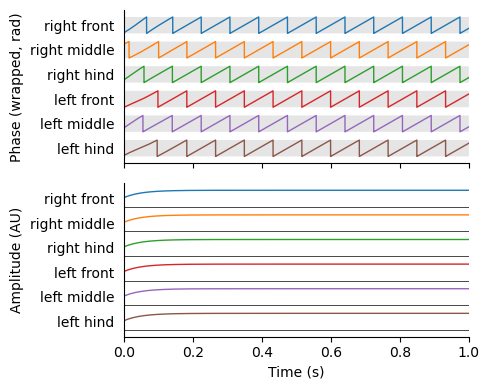

In [6]:
timestep = sim.timestep
legs = ["LF", "LM", "LH", "RF", "RM", "RH"]
rule_labels = ["Retraction", "Stumbling"]
leg_basey_lookup = {
    "right front": 0,
    "right middle": -1,
    "right hind": -2,
    "left front": -3,
    "left middle": -4,
    "left hind": -5,
}
leg_name_lookup = {
    "RF": "right front",
    "LF": "left front",
    "RM": "right middle",
    "LM": "left middle",
    "RH": "right hind",
    "LH": "left hind",
}
color_lookup = {
    "RF": "C0",
    "RM": "C1",
    "RH": "C2",
    "LF": "C3",
    "LM": "C4",
    "LH": "C5",
}

time = timestep * np.arange(len(phases))


def plot_frame(video_layout=False):
    if video_layout:
        fig, axs = plt.subplots(1, 2, sharex=True, figsize=(10, 2), tight_layout=True)
    else:
        fig, axs = plt.subplots(2, 1, sharex=True, figsize=(5, 4), tight_layout=True)

    lines = []

    # phase plot
    ax = axs.flatten()[0]
    for i, leg_code in enumerate(legs):
        leg_name = leg_name_lookup[leg_code]
        phase_ts = np.mod(phases[:, i], np.pi * 2)
        ax.plot(
            time,
            phase_ts + leg_basey_lookup[leg_name] * np.pi * 3 - np.pi,
            color=color_lookup[leg_code],
            linewidth=1,
        )
        lines.append(ax.axvline(np.nan, color="red", linewidth=2, zorder=100))
        ax.fill_between(
            time,
            leg_basey_lookup[leg_name] * np.pi * 3 - np.pi,
            leg_basey_lookup[leg_name] * np.pi * 3 + np.pi,
            facecolor="gray",
            edgecolor="none",
            alpha=0.2,
            zorder=-1,
            linewidth=1,
        )
    ax.set_yticks(np.array(list(leg_basey_lookup.values())) * np.pi * 3)
    ax.set_yticklabels(list(leg_basey_lookup.keys()))
    ax.set_xlim(0, 1)
    ax.tick_params(left=False)
    ax.set_ylabel("Phase (wrapped, rad)")

    # amplitude plot
    ax = axs.flatten()[1]
    for i, leg_code in enumerate(legs):
        leg_name = leg_name_lookup[leg_code]
        amp_ts = amplitudes[:, i]
        ax.plot(
            time,
            amp_ts + leg_basey_lookup[leg_name] * 1.5 - 0.5,
            color=color_lookup[leg_code],
            linewidth=1,
        )
        lines.append(ax.axvline(np.nan, color="red", linewidth=2, zorder=100))
        ax.axhline(
            leg_basey_lookup[leg_name] * 1.5 - 0.5,
            color="k",
            linestyle="-",
            linewidth=0.5,
            zorder=-1,
        )
    if video_layout:
        ax.set_yticks([])
        ax.set_yticklabels([])
    else:
        ax.set_yticks(np.array(list(leg_basey_lookup.values())) * 1.5)
        ax.set_yticklabels(list(leg_basey_lookup.keys()))
    ax.set_xlim(0, 1)
    ax.tick_params(left=False)
    ax.set_ylabel("Amplitude (AU)")
    ax.set_xlabel("Time (s)")

    sns.despine()
    return fig, lines


plt.style.use("default")
fig, lines = plot_frame()
Path("outputs").mkdir(exist_ok=True)
fig.savefig("outputs/cpg.pdf", transparent=True)

In [7]:
plt.style.use("dark_background")
fig, lines = plot_frame(video_layout=True)

with imageio.get_writer("outputs/cpg.mp4", fps=cam.fps) as writer:
    for t, frame in tqdm(
        zip(t_frames, cam._frames[-len(t_frames) :], strict=True), total=len(t_frames)
    ):
        writer.append_data(merge_frame_and_time_series(fig, lines, t, frame))

plt.close(fig)

  0%|          | 0/299 [00:00<?, ?it/s]WARNING:imageio_ffmpeg:IMAGEIO FFMPEG_WRITER WARNING: input image is not divisible by macro_block_size=16, resizing from (700, 700) to (704, 704) to ensure video compatibility with most codecs and players. To prevent resizing, make your input image divisible by the macro_block_size or set the macro_block_size to 1 (risking incompatibility).
[swscaler @ 0x633cc40] Warning: data is not aligned! This can lead to a speed loss
100%|██████████| 299/299 [00:08<00:00, 33.81it/s]
